#介紹
此專案透過CNN分析新聞文本，並預測該文本的新聞分類

## 安裝、導入套件

In [2]:
!pip install datasets scikit-learn transformers
!pip install datasets scikit-learn tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datasets
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import top_k_accuracy_score
import seaborn as sns

## 導入資料集

In [3]:
ag_news = load_dataset('ag_news')
ag_news

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [4]:
# 指派資料
train_data = ag_news['train']
test_data = ag_news['test']
# 看一下標籤分類
print(train_data.features['label'].names)

['World', 'Sports', 'Business', 'Sci/Tech']


In [5]:
# 訓練資料
# 獲取文本、標籤
train_texts = [sample['text'] for sample in train_data]
train_labels = [sample['label'] for sample in train_data]

# 測試資料
# 獲取文本、標籤
test_texts = [sample['text'] for sample in test_data]
test_labels = [sample['label'] for sample in test_data]

# 打印結果
print(train_texts[0])  # 看看index0的資料
print(train_labels[0])  # 被標籤為Business分類

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
2


## 第一個textCNN

### 文本tokenization

In [ ]:
# 文本轉成token(數字)
tokenizer = Tokenizer(num_words=max_features)  # 設定詞彙表大小

# 擬和tokenizer到訓練資料
tokenizer.fit_on_texts(train_texts) # 讀取所有訓練集的文本(train_texts)，從中建立一個內部詞彙表

# 將文本轉成序列
X_train = tokenizer.texts_to_sequences(train_texts)
X_test = tokenizer.texts_to_sequences(test_texts)

### 序列填充

In [ ]:
# 截斷序列最大長度
maxlen = 500
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

# 獲取label，計算類別的數量
num_classes = max(train_labels) + 1

# 把類別標籤轉化成one hot編碼
y_train = to_categorical(train_labels, num_classes)
y_test = to_categorical(test_labels, num_classes)

## 建模

*   TextCNN可透過捲基層捕捉局部相依性，增強模型對文本的理解能力並分類



In [ ]:
# 模型參數設定
embedding_dim = 100  # embedding向量維度
max_features = 20000  # 設定詞彙表大小
embedding_matrix = None  # 不隨機初始化embedding矩陣

# 建立模型輸入和embedding層
sequence_input = tf.keras.Input(shape=(maxlen,), dtype='int32')  # 定義輸入層，接收上限maxlen(500)的整數序列
embedding_seqeunces = tf.keras.layers.Embedding(max_features, embedding_dim, input_length=maxlen)(sequence_input)  # 把輸入的每個整數(詞)轉成100維向量

# 建立卷積層和池化層
conv = []
filter_sizes = [3,4,5]  # 卷積核大小為3,4,5
for fsz in filter_sizes:
  l_conv = tf.keras.layers.Conv1D(filters=100, kernel_size=fsz, activation='relu')(embedding_seqeunces)  # 使用100個filters，卷積核大小為fsz，激活函數為ReLU，embedding_seqeunces是上面定義的嵌入序列。
  l_pool = tf.keras.layers.MaxPooling1D()(l_conv)  # 最大池化將卷積層的輸出進行池化，池化大小未指定默認為2。
  conv.append(l_pool)  # 池化層的輸出添加到conv

# 合併不同的卷積核結果
l_merge = tf.keras.layers.Concatenate(axis=1)(conv)  # axis=1代表沿著高度合併(batch_size, height, width, channels)

# 創建模型 conv_model
conv_model = tf.keras.Model(sequence_input, l_merge)

x = conv_model.output  # 卷積層輸出

x = tf.keras.layers.Flatten()(x)  # 攤平卷積層輸出：多維轉一維
# 新增dropout層避免overfitting
x = tf.keras.layers.Dropout(0.5)(x)
# 加兩層fully conection層(Dense)
x = tf.keras.layers.Dense(256, activation='relu')(x)
preds = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(conv_model.input, preds)

# 查看最終模型
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 500, 100)             2000000   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 498, 100)             30100     ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 497, 100)             40100     ['embedding[0][0]']           
                                                                                            

In [ ]:
# 模型編譯
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])  # 損失函數:categorical crossentropy,優化器:rmsprop
# 訓練模型
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)  # 訓練10輪每批次128個樣本

Epoch 1/10
938/938 [==============================] - 60s 58ms/step - loss: 0.4102 - accuracy: 0.8439 - val_loss: 0.2795 - val_accuracy: 0.9074
Epoch 2/10
938/938 [==============================] - 39s 41ms/step - loss: 0.2181 - accuracy: 0.9269 - val_loss: 0.2625 - val_accuracy: 0.9136
Epoch 3/10
938/938 [==============================] - 40s 42ms/step - loss: 0.1814 - accuracy: 0.9392 - val_loss: 0.2498 - val_accuracy: 0.9163
Epoch 4/10
938/938 [==============================] - 38s 40ms/step - loss: 0.1499 - accuracy: 0.9496 - val_loss: 0.2470 - val_accuracy: 0.9224
Epoch 5/10
938/938 [==============================] - 38s 41ms/step - loss: 0.1181 - accuracy: 0.9604 - val_loss: 0.2692 - val_accuracy: 0.9182
Epoch 6/10
938/938 [==============================] - 38s 40ms/step - loss: 0.0885 - accuracy: 0.9707 - val_loss: 0.3055 - val_accuracy: 0.9183
Epoch 7/10
938/938 [==============================] - 37s 40ms/step - loss: 0.0648 - accuracy: 0.9786 - val_loss: 0.3633 - val_accuracy:

In [ ]:
# 在測試集評估模型
scores = model.evaluate(X_test, y_test, verbose = 1)  # scores：[loss, accuracy]
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

238/238 [==============================] - 2s 6ms/step - loss: 0.4684 - accuracy: 0.9154
Test loss: 0.4684268534183502
Test accuracy: 0.9153947234153748


## 評估模型

#### 1. 混淆矩陣

In [ ]:
# 在測試集上取得預測結果
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

238/238 [==============================] - 1s 4ms/step


array([2, 3, 3, ..., 1, 2, 2])

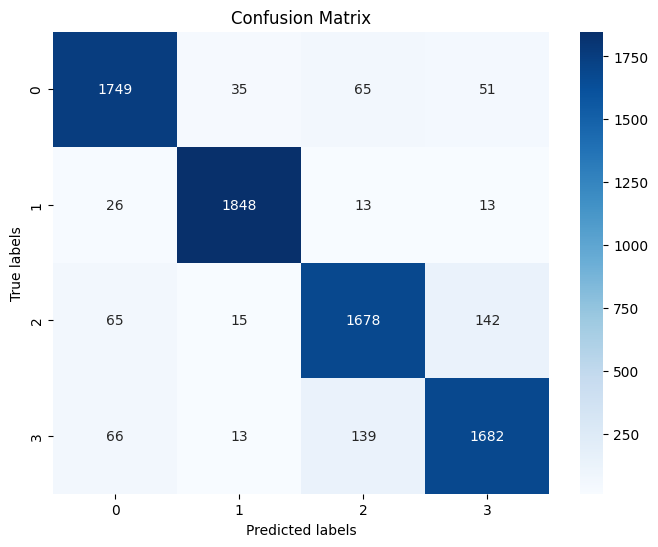

In [ ]:
# 計算混淆矩陣
cm = confusion_matrix(test_labels, y_pred)
# 繪製混淆矩陣表格
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#### 2.準確率和loss曲線

In [ ]:
# 看看歷史訓練紀錄
history.history

{'loss': [0.4101753830909729,
  0.2180595099925995,
  0.18135032057762146,
  0.1498803198337555,
  0.11806835979223251,
  0.08846303075551987,
  0.064788818359375,
  0.04818755388259888,
  0.038102347403764725,
  0.030896956101059914],
 'accuracy': [0.8439333438873291,
  0.9269000291824341,
  0.939175009727478,
  0.9495999813079834,
  0.9604499936103821,
  0.9707333445549011,
  0.9786333441734314,
  0.9841833114624023,
  0.9873416423797607,
  0.9897333383560181],
 'val_loss': [0.2795064151287079,
  0.2624761164188385,
  0.24980004131793976,
  0.24699683487415314,
  0.269153356552124,
  0.30548492074012756,
  0.3632819652557373,
  0.3826112449169159,
  0.4266892671585083,
  0.4684269428253174],
 'val_accuracy': [0.9073684215545654,
  0.9135526418685913,
  0.9163157939910889,
  0.9223684072494507,
  0.9181578755378723,
  0.9182894825935364,
  0.9111841917037964,
  0.9113157987594604,
  0.9121052622795105,
  0.9153947234153748]}

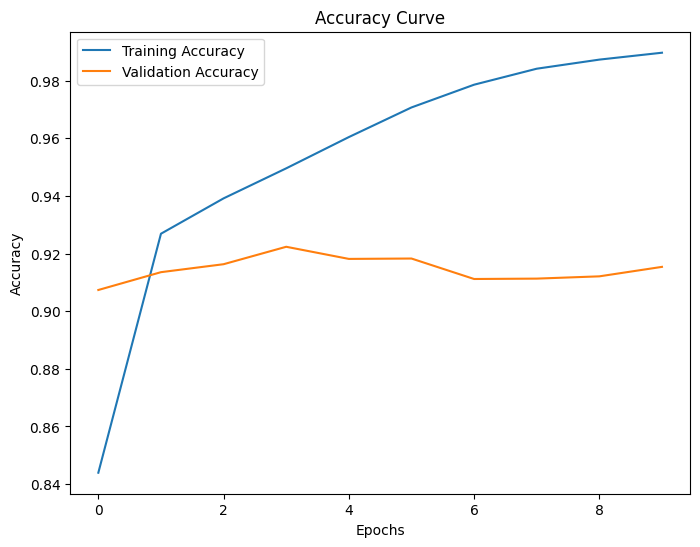

In [ ]:
# 繪製準確率(Accuracy)曲線
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

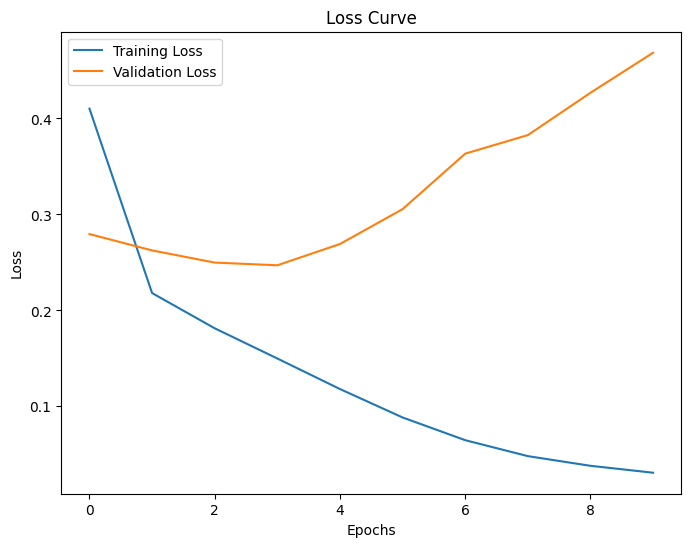

In [ ]:
# 繪製損失(loss)曲線
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

#### 3. Top-K準確率




In [ ]:
y_pred_prob = model.predict(X_test)

top1_acc = top_k_accuracy_score(test_labels, y_pred_prob, k=1)
top3_acc = top_k_accuracy_score(test_labels, y_pred_prob, k=3)

print(f'Top-1 Accuracy: {top1_acc:.4f}')
print(f'Top-3 Accuracy: {top3_acc:.4f}')

238/238 [==============================] - 1s 4ms/step
Top-1 Accuracy: 0.9154
Top-3 Accuracy: 0.9968


## 預測結果視覺化

#### 1. 柱狀圖

In [ ]:
# 先確認標籤名稱
label_list = train_data.features['label'].names
label_list

['World', 'Sports', 'Business', 'Sci/Tech']

238/238 [==============================] - 1s 4ms/step
[1906 1911 1895 1888]


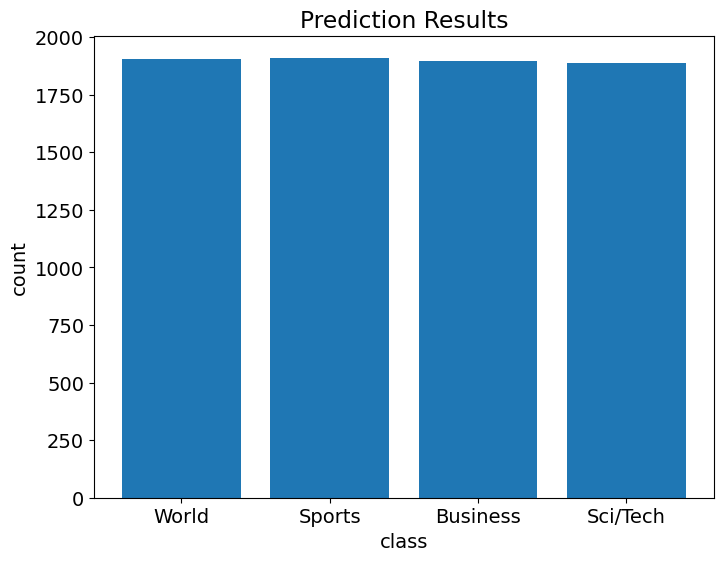

In [ ]:
# x軸: 不同新聞類別
# y軸: 該類別被預測的數量
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# 計算每個類別的預測數量
counts = np.bincount(y_pred, minlength=len(label_list)) # 確保counts長度跟label_list一致
print(counts)

# 設定圖片大小字體大小
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})

# 繪製柱狀圖
plt.bar(range(len(counts)), counts)
plt.xlabel('class')
plt.ylabel('count')
plt.title('Prediction Results')
plt.xticks(range(len(counts)), label_list)
plt.show()

### 2. 預測結果表格


*   根據預測結果與標籤創建一個DataFrame，使用pandas的groupby和size
*   統計每個類別預測數量、類別索引跟實際類別名稱map



In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# 創建Dataframe
data = {'Predicted': y_pred, 'Count':1}
df = pd.DataFrame(data)
df = df.groupby('Predicted').size().reset_index(name='Count')
df['Class'] = df['Predicted'].map({i: label for i, label in enumerate(label_list)})  # 預測類別轉名稱
df = df[['Class', 'Count']]
df

display(df.style.set_caption('Prediction Results'))

238/238 [==============================] - 1s 4ms/step


,Class,Count
0,World,1906
1,Sports,1911
2,Business,1895
3,Sci/Tech,1888


### 預測

In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# 創建dataframe
data = {
    'Predicted Label': [label_list[label_idx] for label_idx in y_pred_labels],
    'Text': test_texts
}
df = pd.DataFrame(data)

# 顯示前10筆結果
df.head(10)

238/238 [==============================] - 1s 4ms/step


,Predicted Label,Text
0,Business,Fears for T N pension after talks Unions repre...
1,Sci/Tech,The Race is On: Second Private Team Sets Launc...
2,Sci/Tech,Ky. Company Wins Grant to Study Peptides (AP) ...
3,Sci/Tech,Prediction Unit Helps Forecast Wildfires (AP) ...
4,Sci/Tech,Calif. Aims to Limit Farm-Related Smog (AP) AP...
5,Sci/Tech,Open Letter Against British Copyright Indoctri...
6,Sci/Tech,"Loosing the War on Terrorism \\""Sven Jaschan, ..."
7,Sci/Tech,"FOAFKey: FOAF, PGP, Key Distribution, and Bloo..."
8,Sci/Tech,E-mail scam targets police chief Wiltshire Pol...
9,Business,"Card fraud unit nets 36,000 cards In its first..."


In [ ]:
# 也可以直接指定看某一筆資料
print('Predicted label:', df['Predicted Label'][1])
print('Text:', df['Text'][1])

Predicted label: Sci/Tech
Text: The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.


In [ ]:
# 計算每類別出現次數
df['Predicted Label'].value_counts()

Predicted Label
Sports      1911
World       1906
Business    1895
Sci/Tech    1888
Name: count, dtype: int64

In [ ]:
# 篩選特定類別的預測結果
df[df['Predicted Label'] == 'World'].head(10)

,Predicted Label,Text
32,World,Sister of man who died in Vancouver police cus...
33,World,"Man Sought #36;50M From McGreevey, Aides Say ..."
34,World,"Explosions Echo Throughout Najaf NAJAF, Iraq -..."
35,World,"Frail Pope Celebrates Mass at Lourdes LOURDES,..."
36,World,Venezuela Prepares for Chavez Recall Vote Supp...
37,World,1994 Law Designed to Preserve Guard Jobs (AP) ...
38,World,Iran Warns Its Missiles Can Hit Anywhere in Is...
39,World,"Afghan Army Dispatched to Calm Violence KABUL,..."
42,World,Politics an Afterthought Amid Hurricane (AP) A...
46,World,"Venezuelans Flood Polls, Voting Extended CARA..."


In [ ]:
# 看看文本長度的統計訊息
df['Text Length'] = df['Text'].apply(len)
df.describe()  # 平均每個文本約235.3個字

,Text Length
count,7600.000000
mean,235.299211
std,65.302023
min,100.000000
25%,196.750000
50%,231.000000
75%,266.000000
max,892.000000


## 第二個textCNN(微調)

再度載入資料集(重置)

In [4]:
ag_news = load_dataset('ag_news')
# 指派資料
train_data = ag_news['train']
test_data = ag_news['test']
# 看一下標籤分類
print(train_data.features['label'].names)
# 訓練資料
# 獲取文本、標籤
train_texts = [sample['text'] for sample in train_data]
train_labels = [sample['label'] for sample in train_data]

# 測試資料
# 獲取文本、標籤
test_texts = [sample['text'] for sample in test_data]
test_labels = [sample['label'] for sample in test_data]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

['World', 'Sports', 'Business', 'Sci/Tech']


### unknown token(UNK)


1.   unknown token的作用，就是讓模型可以處理掉沒見過的詞
2.   詞彙大小限制: 只保留最常見20000個單詞，如果訓練或是後來輸入的文本出現了這20000個單字以外的詞，就需要用unknown token來處理




In [5]:
# 文本轉成token(標記、單詞索引)
tokenizer = Tokenizer(num_words=20000, oov_token='<UNK>') # 限制詞彙表大小

# 擬和tokenizer到訓練資料
tokenizer.fit_on_texts(train_texts) # 讀取所有訓練集的文本(train_texts)建立一個基於這些文本的內部詞彙表

# 設置未知詞<UNK>的index
tokenizer.word_index['<UNK>'] = 1

# 將訓練文本轉成序列
X_train = tokenizer.texts_to_sequences(train_texts)

# 將測試文本轉成序列
X_test = tokenizer.texts_to_sequences(test_texts)

In [6]:
# 序列最大長度限制
maxlen = 500

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [7]:
# 獲取label
# 計算類別的數量
num_classes = max(train_labels) + 1

In [8]:
# one-hot encoding
# 把類別標籤轉化成one hot編碼
y_train = to_categorical(train_labels, num_classes)
y_test = to_categorical(test_labels, num_classes)

### 建模(用第一個模型做調整)

In [9]:
tokenizer.word_index

{'<UNK>': 1,
 'the': 2,
 'to': 3,
 'a': 4,
 'of': 5,
 'in': 6,
 'and': 7,
 'on': 8,
 'for': 9,
 '39': 10,
 's': 11,
 'that': 12,
 'with': 13,
 'as': 14,
 'at': 15,
 'its': 16,
 'is': 17,
 'new': 18,
 'by': 19,
 'said': 20,
 'it': 21,
 'reuters': 22,
 'has': 23,
 'from': 24,
 'an': 25,
 'ap': 26,
 'his': 27,
 'will': 28,
 'after': 29,
 'was': 30,
 'gt': 31,
 'us': 32,
 'lt': 33,
 'be': 34,
 'over': 35,
 'have': 36,
 'up': 37,
 'their': 38,
 'two': 39,
 'first': 40,
 'are': 41,
 'quot': 42,
 'year': 43,
 'but': 44,
 'more': 45,
 'he': 46,
 'u': 47,
 'this': 48,
 '1': 49,
 'one': 50,
 'world': 51,
 'monday': 52,
 'out': 53,
 'oil': 54,
 'wednesday': 55,
 'tuesday': 56,
 'thursday': 57,
 'company': 58,
 '2': 59,
 'not': 60,
 'against': 61,
 'inc': 62,
 'friday': 63,
 'than': 64,
 'into': 65,
 'last': 66,
 'about': 67,
 'b': 68,
 'york': 69,
 'they': 70,
 'who': 71,
 'three': 72,
 'yesterday': 73,
 'iraq': 74,
 'no': 75,
 'president': 76,
 'were': 77,
 'million': 78,
 'game': 79,
 'microsof

In [10]:
print(len(train_data.features['label'].names))
print(set(train_labels))

4
{0, 1, 2, 3}


### 建模

In [11]:
# 計算詞彙表大小
vocab_size = len(tokenizer.word_index) + 1

# embedding向量維度
embedding_dim = 100

# 紀錄一共有幾類
num_classes = len(set(train_labels))

# 建立模型輸入和embedding層
sequence_input = tf.keras.Input(shape=(maxlen,), dtype='int32')
embedding_seqeunces = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen, mask_zero=True)(sequence_input)

# 建立卷積層和池化層
conv = []
filter_sizes = [3,4,5]
for fsz in filter_sizes:
  # L1正規化器: 使權重變得稀疏，可將不重要的權重降為0，有助於特徵選擇
  l_conv = tf.keras.layers.Conv1D(filters=128, kernel_size=fsz, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.001))(embedding_seqeunces)  # 比原模型新增了一個係數0.001的L1正規化器
  l_pool = tf.keras.layers.MaxPooling1D()(l_conv)
  conv.append(l_pool)

# 合併不同的卷積層
x = tf.keras.layers.Concatenate(axis=1)(conv)

# 對卷積層輸出攤平
x = tf.keras.layers.Flatten()(x)

# 新增dropout層減少overfitting
x = tf.keras.layers.Dropout(0.6)(x)

# 加兩層fully conection層(Dense)
# L2正規化器：使權重係數變小但不為0，讓權重分布更平滑，有助於防止overfitting
x = tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # 比原模型新增一個係數0.001的L2正規化器
preds = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# 建立模型
model = tf.keras.Model(sequence_input, preds)

# 查看最終模型
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 500, 100)             7034600   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 498, 128)             38528     ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 497, 128)             51328     ['embedding[0][0]']           
                                                                                              

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) #調整學習率
# 模型編譯
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [13]:
# 處理類別不平衡的資料集，避免模型訓練時忽略少數的類別導致overfitting
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)  # 這段在計算並調整類別權重：1.平衡類別權重 2.取得所有不重複標籤 3.設定訓練集標籤
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}  # 確認調整後的類別權重
class_weight_dict

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

In [14]:
# 使用EarlyStopping的Callback提前停止訓練
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)  # 接續2次內的迭代若沒有改善效果就會停止迭代，並以最後一次的改善權重作為最優模型來使用

#　設定模型儲存名稱，只有在結果有改善時才會儲存，透過監控損失來判別有沒有改善，希望讓損失越小越好，且會一直保存過去訓練效果最佳的模型
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True,monitor="val_loss", mode="min")

In [15]:
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_test, y_test), class_weight=class_weight_dict, callbacks=[early_stop, checkpoint])

Epoch 1/20
1874/1875 [============================>.] - ETA: 0s - loss: 0.7417 - accuracy: 0.8434

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1875/1875 [==============================] - 96s 48ms/step - loss: 0.7416 - accuracy: 0.8434 - val_loss: 0.4096 - val_accuracy: 0.9038
Epoch 2/20
1875/1875 [==============================] - 60s 32ms/step - loss: 0.3718 - accuracy: 0.9122 - val_loss: 0.3746 - val_accuracy: 0.9088
Epoch 3/20
1875/1875 [==============================] - 60s 32ms/step - loss: 0.3286 - accuracy: 0.9239 - val_loss: 0.3662 - val_accuracy: 0.9104
Epoch 4/20
1875/1875 [==============================] - 61s 32ms/step - loss: 0.3031 - accuracy: 0.9330 - val_loss: 0.3594 - val_accuracy: 0.9122
Epoch 5/20
1875/1875 [==============================] - 59s 31ms/step - loss: 0.2840 - accuracy: 0.9386 - val_loss: 0.3585 - val_accuracy: 0.9155
Epoch 6/20
1875/1875 [==============================] - 58s 31ms/step - loss: 0.2667 - accuracy: 0.9452 - val_loss: 0.3643 - val_accuracy: 0.9153
Epoch 7/20
1875/1875 [==============================] - 57s 31ms/step - loss: 0.2546 - accuracy: 0.9493 - val_loss: 0.3669 - val_accura

In [16]:
# 在測試集評估模型
scores = model.evaluate(X_test, y_test, verbose = 1)  # scores：[loss, accuracy]
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

238/238 [==============================] - 2s 6ms/step - loss: 0.3669 - accuracy: 0.9149
Test loss: 0.36694568395614624
Test accuracy: 0.9148684144020081


### 評估模型

#### 1. 混淆矩陣

In [17]:
# 在測試集上取得預測結果
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

238/238 [==============================] - 1s 4ms/step


array([2, 3, 3, ..., 1, 2, 2])

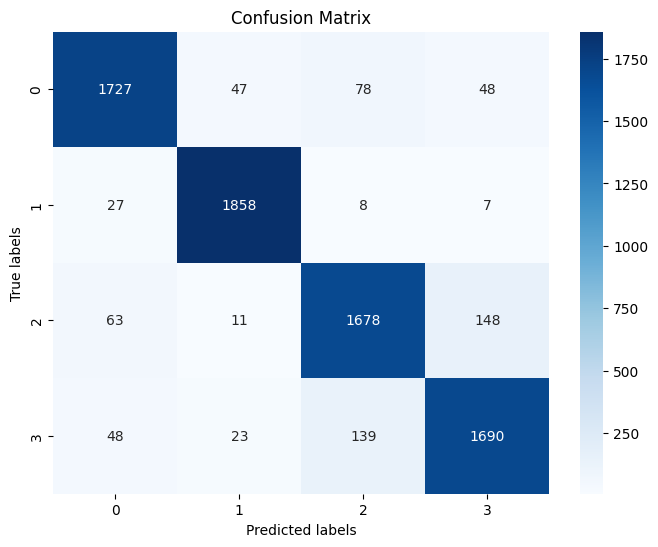

In [18]:
# 計算混淆矩陣
cm = confusion_matrix(test_labels, y_pred)
# 繪製混淆矩陣表格
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


#### 2.準確率和loss曲線

In [19]:
# 看看歷史訓練紀錄
history.history

{'loss': [0.7416383624076843,
  0.3718205988407135,
  0.3286206126213074,
  0.3031359612941742,
  0.28401386737823486,
  0.2666822075843811,
  0.2546093165874481],
 'accuracy': [0.8433916568756104,
  0.9121583104133606,
  0.9238916635513306,
  0.9329666495323181,
  0.9386249780654907,
  0.9452416896820068,
  0.9492999911308289],
 'val_loss': [0.40963584184646606,
  0.3745555877685547,
  0.3662245571613312,
  0.3594339191913605,
  0.3584672510623932,
  0.3643489480018616,
  0.36694586277008057],
 'val_accuracy': [0.9038158059120178,
  0.9088158011436462,
  0.9103947281837463,
  0.9122368693351746,
  0.9155263304710388,
  0.9152631759643555,
  0.9148684144020081]}

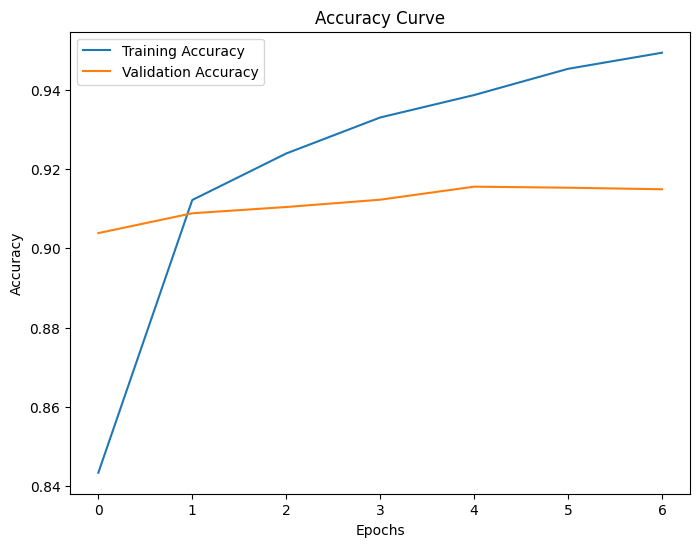

In [20]:
# Accuracy 準確率曲線
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

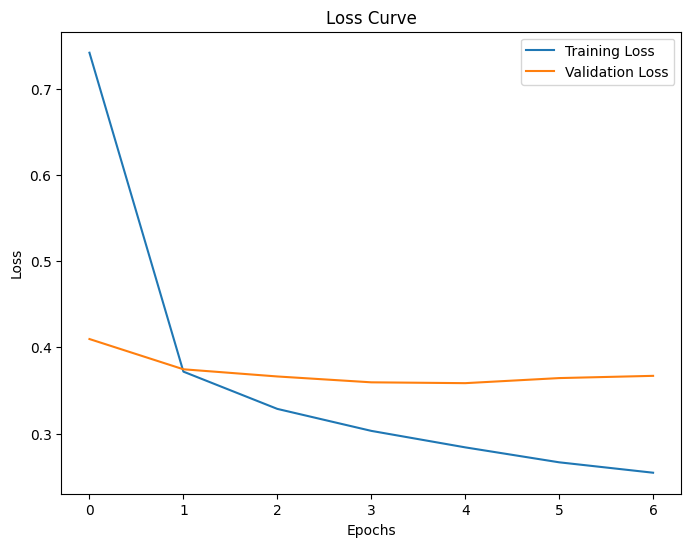

In [21]:
# loss曲線
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

### 分析預測結果(反向分析)

In [24]:
label_list = train_data.features['label'].names

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# 創建dataframe
data = {
    'Text': test_texts,
    'True Label': [label_list[label_idx] for label_idx in test_labels],
    'Predicted Label': [label_list[label_idx] for label_idx in y_pred_labels],

}
df = pd.DataFrame(data)
df.head(20)

238/238 [==============================] - 2s 8ms/step


,Text,True Label,Predicted Label
0,Fears for T N pension after talks Unions repre...,Business,Business
1,The Race is On: Second Private Team Sets Launc...,Sci/Tech,Sci/Tech
2,Ky. Company Wins Grant to Study Peptides (AP) ...,Sci/Tech,Sci/Tech
3,Prediction Unit Helps Forecast Wildfires (AP) ...,Sci/Tech,Sci/Tech
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,Sci/Tech,Sci/Tech
5,Open Letter Against British Copyright Indoctri...,Sci/Tech,Sci/Tech
6,"Loosing the War on Terrorism \\""Sven Jaschan, ...",Sci/Tech,Sci/Tech
7,"FOAFKey: FOAF, PGP, Key Distribution, and Bloo...",Sci/Tech,Sci/Tech
8,E-mail scam targets police chief Wiltshire Pol...,Sci/Tech,Sci/Tech
9,"Card fraud unit nets 36,000 cards In its first...",Sci/Tech,Sci/Tech


In [25]:
# 對比分析：看看預測錯誤的例子
incorrect_predictions = df[df['True Label'] != df['Predicted Label']]
print('不正確預測:', incorrect_predictions)

不正確預測:                                                    Text True Label  \
20    IBM to hire even more new workers By the end o...   Sci/Tech   
23    Some People Not Eligible to Get in on Google I...   Sci/Tech   
24    Rivals Try to Turn Tables on Charles Schwab By...   Sci/Tech   
36    Venezuela Prepares for Chavez Recall Vote Supp...      World   
55    Promoting a Shared Vision As Michael Kaleko ke...   Sci/Tech   
...                                                 ...        ...   
7564  Russia shrugs off US court freeze on oil giant...   Business   
7566  Cisco invests \$12 million in Japan R amp;D ce...   Sci/Tech   
7567  This week in merger news This week saw three m...   Sci/Tech   
7585  Pricey Drug Trials Turn Up Few New Blockbuster...      World   
7589  The Newest Hope ; Marriage of Necessity Just M...     Sports   

     Predicted Label  
20          Business  
23          Business  
24          Business  
36          Business  
55          Business  
...           

In [28]:
# 看看預測錯的詳細資料
print(incorrect_predictions['Text'][20])
print('True label:',incorrect_predictions['True Label'][20])
print('Predict label:',incorrect_predictions['Predicted Label'][20])

IBM to hire even more new workers By the end of the year, the computing giant plans to have its biggest headcount since 1991.
True label: Sci/Tech
Predict label: Business


True Label
Business    222
Sci/Tech    210
World       173
Sports       42
Name: count, dtype: int64


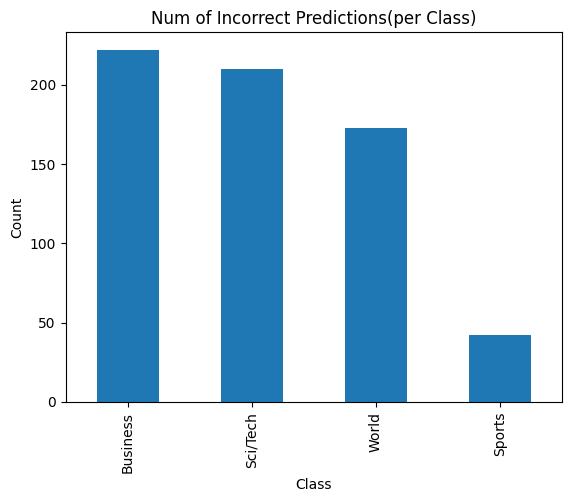

In [29]:
# 畫長條圖看看預測錯誤的分布
incorrect_counts = incorrect_predictions['True Label'].value_counts()
print(incorrect_counts)
incorrect_counts.plot(kind='bar', title='Num of Incorrect Predictions(per Class)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()